# Data Acquisition and Sample Construction for Filmmaker Career Longevity Analysis

Creative careers are fragile and movie directing is no exception. Most directors make one film and disappear; while a small number keep making movies for decades. What separates the two? Understanding this helps us see how creative industries nurture and retain emerging talent.

To do that, we need full career histories. In this notebook, I use IMDb to build a population-level dataset of 63,169 directorsho debuted between 2003 and 2013, and the 115,413 movies they made through 2023. It’s a rare, population-level view of how directing careers unfold across the global film industry.

In this notebook, I pull the raw data from IMDb, find debut directors, map every film they’ve made, and gather information about the roles they held before directing. In the next notebooks, I turn these timelines into a structure we can actually model (time series), so we can answer the big question: *what helps a filmmaker stick around while so many drop out?*

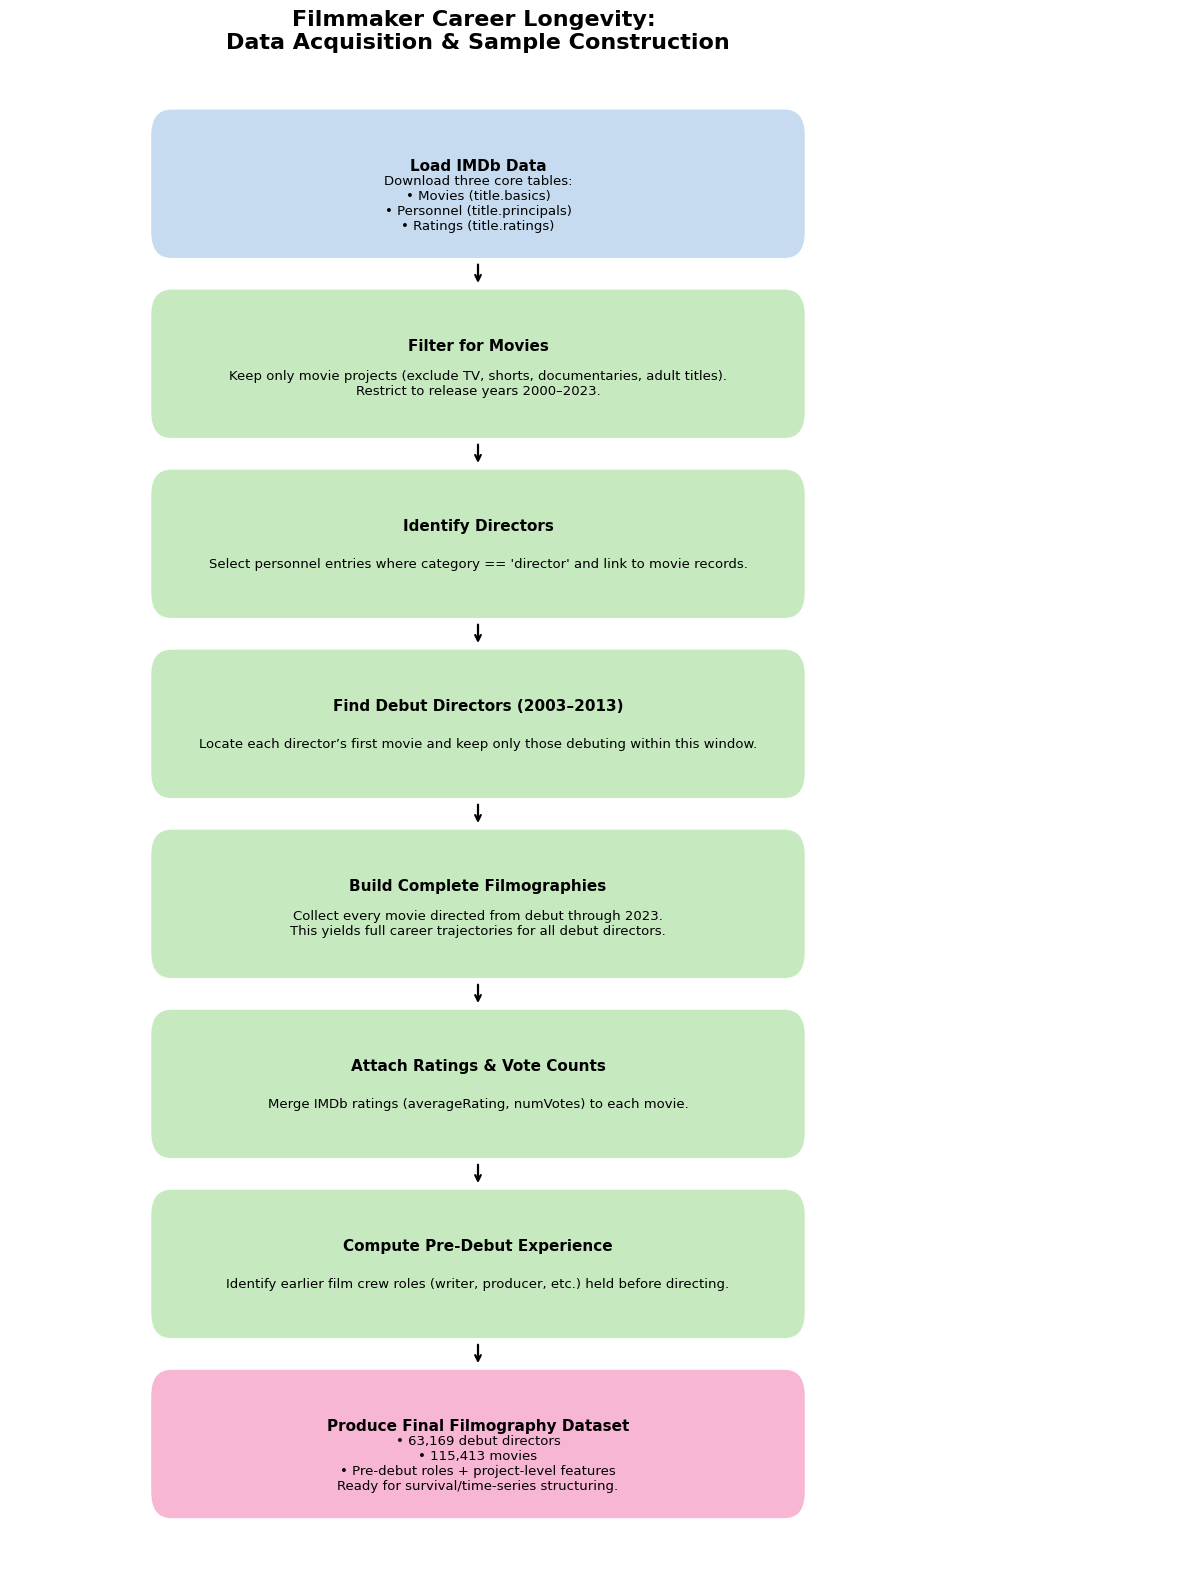

In [31]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# --- Figure (tall for clean spacing) ---
fig, ax = plt.subplots(figsize=(12, 16))
ax.axis("off")

# --- Colors by phase ---
colors = {
    "data": "#c6dbef",      # data collection / loading
    "cleaning": "#c7e9c0",    # cleaning / filtering
    "output": "#f7b6d3"     # final dataset
}

# --- Workflow steps ---
steps = [
    (
        "Load IMDb Data",
        "Download three core tables:\n"
        "• Movies (title.basics)\n"
        "• Personnel (title.principals)\n"
        "• Ratings (title.ratings)",
        "data"
    ),
    (
        "Filter for Movies",
        "Keep only movie projects (exclude TV, shorts, documentaries, adult titles).\n"
        "Restrict to release years 2000–2023.",
        "cleaning"
    ),
    (
        "Identify Directors",
        "Select personnel entries where category == 'director' and link to movie records.",
        "cleaning"
    ),
    (
        "Find Debut Directors (2003–2013)",
        "Locate each director’s first movie and keep only those debuting within this window.",
        "cleaning"
    ),
    (
        "Build Complete Filmographies",
        "Collect every movie directed from debut through 2023.\n"
        "This yields full career trajectories for all debut directors.",
        "cleaning"
    ),
    (
        "Attach Ratings & Vote Counts",
        "Merge IMDb ratings (averageRating, numVotes) to each movie.",
        "cleaning"
    ),
    (
        "Compute Pre-Debut Experience",
        "Identify earlier film crew roles (writer, producer, etc.) held before directing.",
        "cleaning"
    ),
    (
        "Produce Final Filmography Dataset",
        "• 63,169 debut directors\n"
        "• 115,413 movies\n"
        "• Pre-debut roles + project-level features\n"
        "Ready for survival/time-series structuring.",
        "output"
    ),
]


# --- Layout parameters (smaller bars) ---
N = len(steps)
top_margin = 0.95
bottom_margin = 0.05

box_h = 0.04        # smaller box height
v_gap = 0.08          # vertical gap between boxes
step_pitch = box_h + v_gap

left = 0.15           # left x for boxes
box_w = 0.5          # width for readable text
text_pad_y = 0.002

# --- Draw boxes + arrows ---
for i, (title, text, category) in enumerate(steps):
    color = colors[category]

    # Compute box geometry
    y_top = top_margin - (i * step_pitch)
    y_box_bottom = y_top - box_h

    # Rounded rectangle
    box = FancyBboxPatch(
        (left, y_box_bottom), box_w, box_h,
        boxstyle="round,pad=0.03,rounding_size=0.018",
        facecolor=color, edgecolor="white", linewidth=1.2
    )
    ax.add_patch(box)

    # Bold title + regular description on separate lines
    ax.text(
        left + box_w / 2,
        y_box_bottom + box_h / 2 + text_pad_y + 0.01,
        title,
        ha="center", va="center",
        fontsize=11, fontweight="bold"
    )
    ax.text(
        left + box_w / 2,
        y_box_bottom + box_h / 2 + text_pad_y - 0.015,
        text,
        ha="center", va="center",
        fontsize=9.5, fontweight="regular"
    )

    # Arrow from bottom of this box to top of next box
    if i < N - 1:
        next_y_top = top_margin - ((i + 1) * step_pitch)
        y_start = y_box_bottom - 0.4 * v_gap
        y_end = next_y_top + 0.4 * v_gap

        ax.annotate(
            "",
            xy=(left + box_w / 2, y_end),
            xytext=(left + box_w / 2, y_start),
            arrowprops=dict(arrowstyle="->", lw=1.6, color="black")
        )

# --- Title ---
plt.title(
    "Filmmaker Career Longevity: \nData Acquisition & Sample Construction",
    fontsize=16, fontweight="bold", pad=22, x=0.4
)

plt.tight_layout()
plt.show()

# Imports & Setup

In [ ]:
# Imports
import pandas as pd                           # DataFrames
import numpy as np                            # Arrays & math
import matplotlib.pyplot as plt               # Plotting
import seaborn as sns                         # Statistical plotting
import os                                     # File system ops

# Set working directory
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

# Building movie data

We build a dataset that includes every film released between 2000 and 2023 and along with their release year and genres.


In [ ]:
# Data URLs
url_basics = 'https://datasets.imdbws.com/title.basics.tsv.gz'
url_principals = 'https://datasets.imdbws.com/title.principals.tsv.gz'

# Load datasets
df_basics = pd.read_csv(url_basics, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)
df_principals = pd.read_csv(url_principals, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)

In [ ]:
# Quick look at basics
df_basics.head() 

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,\N,1,"Comedy,Short"


In [ ]:
{col: df_basics[col].value_counts() for col in ['titleType', 'isAdult']}

{'titleType': titleType
 tvEpisode       8042282
 short            974875
 movie            669892
 video            287189
 tvSeries         256237
 tvMovie          144193
 tvMiniSeries      52188
 tvSpecial         45647
 videoGame         37276
 tvShort           10240
 tvPilot               1
 Name: count, dtype: int64,
 'isAdult': isAdult
 0       10185807
 1         334195
 2023           6
 2019           3
 2020           2
 1981           1
 2017           1
 \N             1
 2022           1
 2011           1
 2014           1
 2005           1
 Name: count, dtype: int64}

In [ ]:
# Clean startYear
df_basics['startYear'] = pd.to_numeric(df_basics['startYear'], errors='coerce')

# Filter for non-adult movies with valid years
movies = (df_basics
          .query('titleType == "movie" & isAdult == "0" & startYear == startYear') 
          .filter(items=['tconst', 'startYear', 'genres'])  
          )

# Year span
movies.nunique()

tconst       563624
startYear       135
genres         1338
dtype: int64

As of the time of this analysis (Jan 29, 2024), the data includes 563,624 non-pornographic movies spaning 135 years. 

In [ ]:
print("Earliest Year:", movies['startYear'].min())
print("Latest Year:", movies['startYear'].max())

Earliest Year: 1894.0
Latest Year: 2031.0


In [ ]:
# Drop post-2023
movies = movies[movies['startYear'] <= 2023]

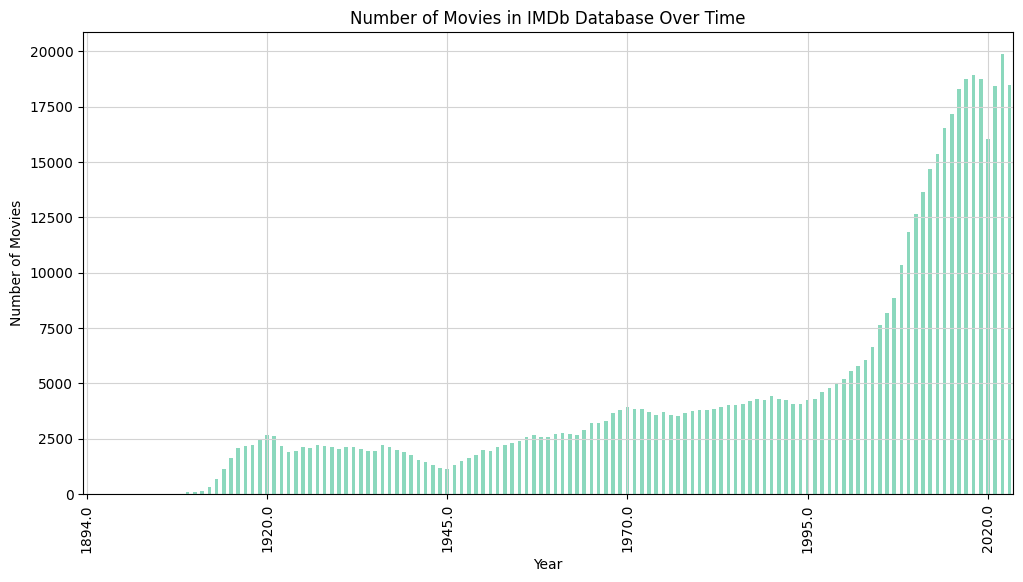

In [ ]:
# Movies per year
movies_per_year = movies.groupby('startYear').size()

# Plot trend
plt.figure(figsize=(12,6))
movies_per_year.plot(kind='bar', color='#8BD8BD')
plt.title('Number of Movies in IMDb Database Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(range(0, len(movies_per_year), 25), labels=movies_per_year.index[::25]) 
plt.grid(True, color='#D3D3D3')
plt.show()


A lot more movies are made in the 21st century than previous centuries. This is probably due to the spread of the internet in the late 90s, which led to a shift towards digital filmmaking and distribution. This made it easier to produce and distribute films. To have a representative look at what the movie industry looks like today, we'll narrow down the dataset to movies released from 2000 to 2023 (present year).

In [ ]:
# Subset 2000–2023 and save
movies_2000_2023 = movies[(movies['startYear'] >= 2000) & (movies['startYear'] <= 2023)]
movies_2000_2023.head()

,tconst,startYear,genres
11634,tt0011801,2019.0,"Action,Crime"
13079,tt0013274,2021.0,Documentary
15174,tt0015414,2000.0,\N
27745,tt0028248,2022.0,Musical
34798,tt0035423,2001.0,"Comedy,Fantasy,Romance"


In [ ]:
# Display unique counts in the subset
movies_2000_2023.nunique()

tconst       313675
startYear        24
genres         1192
dtype: int64

We have 313,675 movies released between 2000 and 2023. 

In [ ]:
# Save the dataset
movies_2000_2023.to_csv('movies_2000_2023.csv', index=False)

# 2. Building director filmography data

We build a dataset includes the complete filmography (to 2023) of directors whose debut fell between 2003 and 2013, with information on each film’s release year, genres, and audience ratings.

In [ ]:
# Inspect principals
df_principals.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [ ]:
# Check unique categories in principals and their counts
df_principals['category'].value_counts()

category
actor                  13322849
self                   10448069
actress                10392402
writer                  8435856
director                6951076
producer                3917208
cinematographer         2050878
editor                  1996902
composer                1996779
archive_footage          397891
production_designer      381792
archive_sound              4516
Name: count, dtype: int64

In [ ]:
# Keep only directors
directors = df_principals[df_principals['category'] == 'director']

# Link to movies
directors = movies.merge(directors[['tconst', 'nconst']], on='tconst', how='inner')

# Director debut years
directors_first_movies = directors.groupby('nconst').agg({'startYear': 'min'}).reset_index()
directors_first_movies = directors_first_movies.rename(columns={'startYear': 'firstYear'})

# Debut between 2003–2013
debut_directors_2003_2013 = directors_first_movies[(directors_first_movies['firstYear'] >= 2003) & (directors_first_movies['firstYear'] <= 2013)]

# Full filmographies
directors_full_filmography = directors[directors['nconst'].isin(debut_directors_2003_2013['nconst'])]
directors_full_filmography = directors_full_filmography.merge(debut_directors_2003_2013, on='nconst', how='left')

In [ ]:
# Check unique counts in directors' full filmography
directors_full_filmography.nunique()

tconst       115413
startYear        21
genres          948
nconst        63169
firstYear        11
dtype: int64

So, our data includes the complete filmographies of 63,169 directors, capturing every movie they've directed since their debut (a total of 115,413 movies). 

In [ ]:
# Add ratings
url_ratings = 'https://datasets.imdbws.com/title.ratings.tsv.gz'
df_ratings = pd.read_csv(url_ratings, sep='\t', compression='gzip')
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2017
1,tt0000002,5.7,270
2,tt0000003,6.5,1943
3,tt0000004,5.4,178
4,tt0000005,6.2,2721


In [ ]:
# Merge the ratings data with the 'directors_full_filmography' dataset
directors_full_filmography = directors_full_filmography.merge(df_ratings, on='tconst', how='left')
directors_full_filmography.to_csv('directors_full_filmography.csv', index=False)

In [ ]:
directors_full_filmography

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004.0,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004.0,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003.0,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008.0,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005.0,Drama,nm0000417,2005.0,5.3,950.0
...,...,...,...,...,...,...,...
128529,tt9916362,2020.0,"Drama,History",nm1893148,2008.0,6.4,5687.0
128530,tt9916538,2019.0,Drama,nm4457074,2011.0,8.6,7.0
128531,tt9916622,2015.0,Documentary,nm9272490,2012.0,NaN,NaN
128532,tt9916754,2013.0,Documentary,nm9272490,2012.0,NaN,NaN


# 3. Building pre-debut experience data

We build a dataset that includes what directors did before they directed, with information on the number of films they worked on, their roles, and whether they had any prior experience.

In [ ]:
# Pre-debut roles
director_roles_pre_debut = df_principals[(df_principals['nconst'].isin(debut_directors_2003_2013['nconst']))]
director_roles_pre_debut = director_roles_pre_debut[['tconst', 'nconst', 'category']].merge(movies[['tconst', 'startYear']], on='tconst', how='inner')
director_roles_pre_debut = director_roles_pre_debut.merge(debut_directors_2003_2013, on='nconst', how='left')

# Summarize pre-debut experience
pre_debut_work = director_roles_pre_debut[director_roles_pre_debut['startYear'] < director_roles_pre_debut['firstYear']]
pre_debut_work = pre_debut_work[pre_debut_work['category'] != "self"]

# Summarize pre-debut experience
pre_debut_experience = pre_debut_work.groupby('nconst').agg({
    'tconst': 'count', 
    'category': lambda x: list(set(x))
    }).rename(columns={'tconst': 'movie_count', 'category': 'roles'})

# Build experience table
directors_experience = pd.DataFrame({'nconst': directors_full_filmography['nconst']}).drop_duplicates()
directors_experience['had_prior_experience'] = 0  # Initializing with 0 (no experience)
directors_experience = directors_experience.merge(pre_debut_experience, on='nconst', how='left')
directors_experience['movie_count'].fillna(0, inplace=True)
directors_experience.loc[directors_experience['movie_count'] > 0, 'had_prior_experience'] = 1

In [ ]:
# Inspect & save
directors_experience

,nconst,had_prior_experience,movie_count,roles
0,nm1131265,0,0.0,NaN
1,nm1130611,0,0.0,NaN
2,nm0290651,0,0.0,NaN
3,nm0404033,0,0.0,NaN
4,nm0000417,1,14.0,"['archive_footage', 'actor']"
...,...,...,...,...
63164,nm4394847,0,0.0,NaN
63165,nm10527671,0,0.0,NaN
63166,nm10532602,0,0.0,NaN
63167,nm4453202,0,0.0,NaN


In [ ]:
directors_experience['movie_count'].value_counts().sort_index()

movie_count
0.0      52850
1.0       5774
2.0       1820
3.0        842
4.0        473
         ...  
106.0        1
112.0        1
124.0        1
160.0        1
163.0        1
Name: count, Length: 76, dtype: int64

The majority of first-time directors (84%) did not work in other movie productions before their directing debut. 

In [ ]:
directors_experience.to_csv('directors_pre_debut_careers.csv', index=False)

# Summary

This notebook built the dataset for our survival modeling of filmmaker career longevity. Specifically, we:

- Filtered IMDb’s movie catalogue

- Identified the 63,169 directors who debuted between 2003 and 2013
    
- Constructed their complete filmographies through 2023 (115,413 movies)

- Added project-level rating features

- Summarized pre-debut experience in other film crew roles

The next notebook will transform this dataset into a time-to-event structure suitable for survival models.